## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [16]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [18]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text_shakespeare = ''.join([line.lower() for line in text])

assert len(text_shakespeare) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [19]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2022-05-28 19:44:43--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.04s   

2022-05-28 19:44:43 (6.78 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [33]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text_onegin = ''.join([line.lower() for line in text])


Put all the characters, that you've seen in the text, into variable `tokens`.

In [34]:
tokens = sorted(set(text_onegin))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [35]:
token_to_idx = {
    e : i for i, e in enumerate(tokens)
}

idx_to_token = {
    i : e for i, e in enumerate(tokens)
}

In [37]:
import numpy as np

In [39]:
encoded_text = np.array([token_to_idx[ch] for ch in text_onegin])

In [40]:
len(tokens)

83

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [24]:
# Your code here
import torch, torch.nn as nn
import torch.nn.functional as F

In [41]:
n_classes = 83
batch_size = 16
seq_length = 50
n_epochs = 30

train_data, val_data = encoded_text[:len(encoded_text) * 8 // 10], encoded_text[len(encoded_text) * 8 // 10:]

In [107]:
len(train_data)

113510

In [111]:
class CharRNN_OHE(nn.Module):
    def __init__(self, n_classes, n_hidden = 256, num_layers=1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.rnn = nn.RNN(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.act = nn.LeakyReLU()
        self.drp = nn.Dropout()
        self.fc = nn.Linear(self.n_hidden, self.n_classes)
        
    def forward(self, x, hid = None):
        if hid == None:
            hid = torch.zeros(self.num_layers, x.size(0), self.n_hidden)
            
        x_ohe = self.emb(x)
        out, hid = self.rnn(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.act(out)
        out = self.drp(out)
        out = self.fc(out)
        return out, hid

In [112]:
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = len(arr) // batch_size_total
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))

    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n + seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n + seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [110]:
from typing import Tuple, List, Type, Dict, Any
import matplotlib.pyplot as plt

In [46]:
def train_model(net, train_data, val_data, criterion, 
                opt, lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau, lr_scheduler_params: Dict = {}):
    val_loss = []
    train_loss = []
    
    lr_scheduler = lr_scheduler_class(opt, **lr_scheduler_params)

    for epoch in range(n_epochs):
                
        ep_val_loss = []
        ep_train_loss = []

        net.train()
        for x, y in get_batches(train_data, batch_size, seq_length):
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            targets = targets.reshape((batch_size * seq_length,))
            
            net.zero_grad()
            output, hidden = net(inputs)

            loss = criterion(output, targets.long())
            loss.backward()
            
            ep_train_loss.append(loss.item())
            opt.step()
            
        net.eval()
        for x, y in get_batches(val_data, batch_size, seq_length):
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            targets = targets.reshape((batch_size * seq_length,))
            
            output, val_hidden = net(inputs)

            loss = criterion(output, targets.long()) 
            
            ep_val_loss.append(loss.item())
        
        lr_scheduler.step(loss.item())
        
        print(f'Epoch {epoch + 1} of {n_epochs}')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")

    return train_loss, val_loss

In [102]:
model_rnn = CharRNN_OHE(n_classes)
opt = torch.optim.Adam(model_rnn.parameters())
criterion = nn.CrossEntropyLoss()

train_loss, val_loss = train_model(model_rnn, train_data, val_data, criterion, opt)

Epoch 1 of 30
	  training loss: 3.423910
	validation loss: 3.295817
Epoch 2 of 30
	  training loss: 3.185479
	validation loss: 2.996445
Epoch 3 of 30
	  training loss: 2.887813
	validation loss: 2.747546
Epoch 4 of 30
	  training loss: 2.726960
	validation loss: 2.623660
Epoch 5 of 30
	  training loss: 2.628680
	validation loss: 2.540603
Epoch 6 of 30
	  training loss: 2.558248
	validation loss: 2.481630
Epoch 7 of 30
	  training loss: 2.499292
	validation loss: 2.436999
Epoch 8 of 30
	  training loss: 2.457494
	validation loss: 2.388475
Epoch 9 of 30
	  training loss: 2.415825
	validation loss: 2.358085
Epoch 10 of 30
	  training loss: 2.385632
	validation loss: 2.331862
Epoch 11 of 30
	  training loss: 2.366772
	validation loss: 2.310457
Epoch 12 of 30
	  training loss: 2.345838
	validation loss: 2.290650
Epoch 13 of 30
	  training loss: 2.324724
	validation loss: 2.276958
Epoch 14 of 30
	  training loss: 2.309027
	validation loss: 2.264259
Epoch 15 of 30
	  training loss: 2.297400
	

Plot the loss function (axis X: number of epochs, axis Y: loss function).

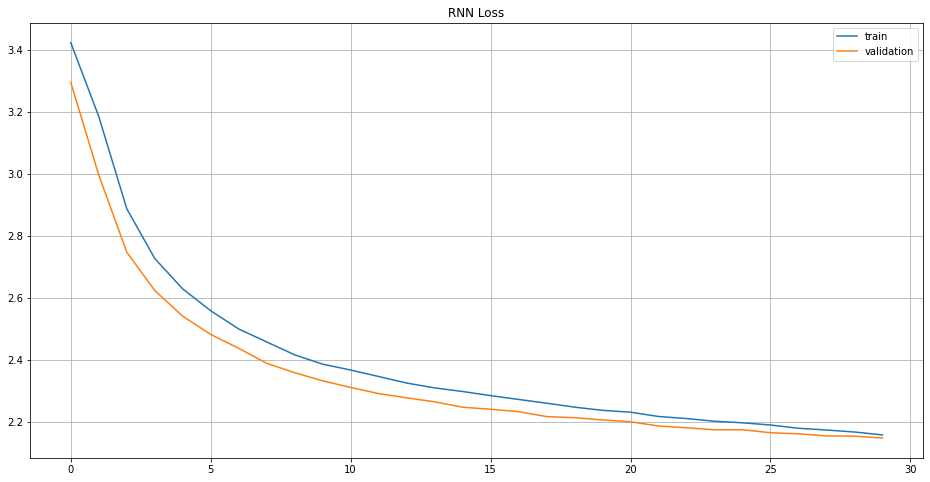

In [103]:
# Your plot code here
plt.figure(figsize=(16, 8))
plt.title('RNN Loss')
plt.xlabel = 'Epochs'
plt.ylabel = 'Value'
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.grid()
plt.legend(); 

In [104]:
def generate_sample(char_rnn, seed_phrase=' привет', max_length=500, temperature=0.2):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = None
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [105]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
print(generate_sample(model_rnn))

 приветный стольной сторой
и молоде сердце верет,
на стольно посли был соледный,
не старит сердца в сердце сердца ворой
в сем не верно пострала сольной
и страсте сердца постола
и страсте сердце сердца посторет,
и постали доворит сердца,
до же страла стольный молодный,
и стари простовой сонец
и постола страстельной подом
и странный сердце поретельный сердца,
когда с постали стариный
и страчный сольно в сердце притом,
и в сем простали с постали сольной,
онегин он сердце в сем не стало,
и странит с


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [80]:
# Your beautiful code here

class CharLSTM_OHE(nn.Module):
    def __init__(self, n_classes, n_hidden = 256, num_layers = 1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.lstm = nn.LSTM(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.act = nn.LeakyReLU()
        self.drp = nn.Dropout()
        self.fc = nn.Linear(self.n_hidden, self.n_classes)
        
    def forward(self, x, hid = None):
        if hid == None:
            hid = (torch.zeros(self.num_layers, x.size(0), self.n_hidden), 
                   torch.zeros(self.num_layers, x.size(0), self.n_hidden))
            
        x_ohe = self.emb(x)
        out, hid = self.lstm(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.act(out)
        out = self.drp(out)
        out = self.fc(out)
        return out, hid

In [81]:
model_lstm = CharLSTM_OHE(n_classes)
opt = torch.optim.Adam(model_lstm.parameters())
criterion = nn.CrossEntropyLoss()

train_loss_lstm, val_loss_lstm = train_model(model_lstm, train_data, val_data, criterion, opt)

Epoch 1 of 30
	  training loss: 3.453941
	validation loss: 3.318359
Epoch 2 of 30
	  training loss: 3.261539
	validation loss: 3.153773
Epoch 3 of 30
	  training loss: 3.067125
	validation loss: 2.941929
Epoch 4 of 30
	  training loss: 2.907692
	validation loss: 2.807006
Epoch 5 of 30
	  training loss: 2.803622
	validation loss: 2.719318
Epoch 6 of 30
	  training loss: 2.733952
	validation loss: 2.660486
Epoch 7 of 30
	  training loss: 2.682416
	validation loss: 2.616137
Epoch 8 of 30
	  training loss: 2.643214
	validation loss: 2.581674
Epoch 9 of 30
	  training loss: 2.609550
	validation loss: 2.548625
Epoch 10 of 30
	  training loss: 2.581424
	validation loss: 2.521363
Epoch 11 of 30
	  training loss: 2.555604
	validation loss: 2.506946
Epoch 12 of 30
	  training loss: 2.533040
	validation loss: 2.480406
Epoch 13 of 30
	  training loss: 2.514457
	validation loss: 2.457931
Epoch 14 of 30
	  training loss: 2.495843
	validation loss: 2.443392
Epoch 15 of 30
	  training loss: 2.477507
	

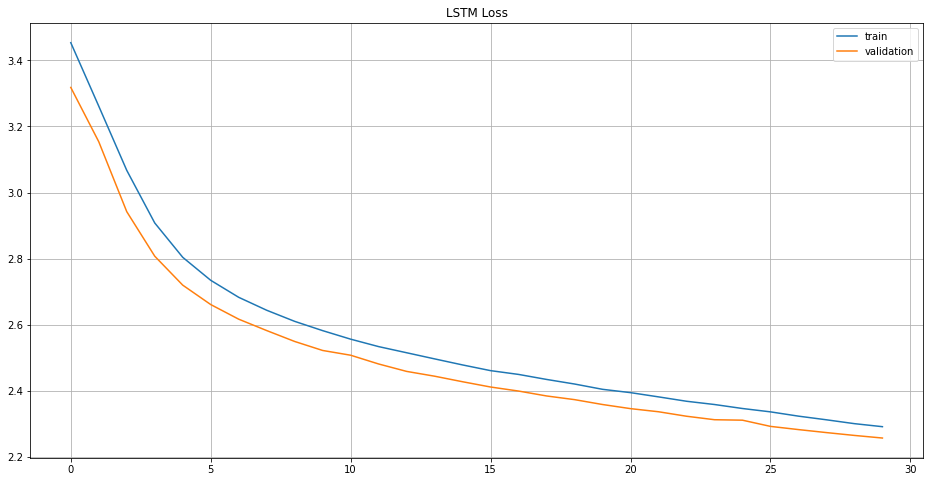

In [82]:
plt.figure(figsize=(16, 8))
plt.title('LSTM Loss')
plt.xlabel = 'Epochs'
plt.ylabel = 'Value'
plt.plot(train_loss_lstm, label='train')
plt.plot(val_loss_lstm, label='validation')
plt.grid()
plt.legend(); 

In [91]:
print(generate_sample(model_lstm))

 приветь не посераний,
и все не сторо страсталиный,
в перет полодо слада сторой
и стора не просталенье,
сталаний стол не страстова,
и мола не постали сторень,
и подол серости на дала
и постали серда с оболины,
постовет не старать и полод
и сторов оне стала не поль
и не постоли в сердце не прода
и в солено поровой водов,
посторный посторов постала
и сторовит сердце стара,
с поров оне столи не стора
и меренен он постолиный,
и сторет и посталений,
но столь состаль и страсталь,
он он стора не потола


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [114]:
# Text generation with different temperature values here
for i in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("Temperature = ", i)
    print(generate_sample(model_lstm, temperature = i),'\n')

Temperature =  0.1
 приветь на восто на стали
и постоль он он он поленный,
в посто на стора с отрадаль
и постовет он посталанье
посторов оне стораний,
и сторов сердце постала
и стора сторов сердце там
и постоли сердце сторать,
и стора с остала не серен
и в сердце странит сердце сторой
и постоль он постовет он оне
на предет постали не ворень,
и сторо не постала на стол
и стора с остала с одала
и сторов и все стора,
и в сердце столи сердце стола
и страсти в сердце стора стора
и в сердце стора с одрадаль
и посталь он 

Temperature =  0.2
 приветь поленье сердали
и полит сердце не сорим.



xxii

не столь воста в серда на сорой
постала на столе не света
и постолов он посталаны,
и всё стростов полого нестой,
в серести стора с остаранный,
в то стала в остора свое нем
и подаль и сердце в сердце столе
и молит сердце посталась,
и в сердце стола с одоной
посталь не воденный старит,
на лода не продали стале
и сторов сторене на ветой
свето комол сердце горова
то стора на сердали водом
и всё на ста

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [99]:
# Saving and loading code here
torch.save(model_lstm, './lstm_onegin.pth')

model_new = torch.load('./lstm_onegin.pth')
print(generate_sample(model_new))

 приветь не поредной стара
и в постала не не сердала
и слада не дено в сердце смола
и простали посталенье,
на стора в сердце постала
и постовель он оне порать,
и постоваль он порем на серой
посталь он поли на постала
и постовой в сердала стала
и морет порене все дали
и страдаль он вене там на стали,
и сторо за сторой настала
и преденный постраталь оне
сторово на мосто посковы,
и простенье в серда порода
и пристали порого насталь,
и стора на постольной там
и воленной посталана,
и стора с осталь о


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)